<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/feature_engineering/2.model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [19]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [20]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

# Grid search
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [21]:
# PEP 8
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

# Import module files

In [22]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}


files = [
    'path_manager.py',
    'sklearn_utils.py',
    'sklearn_transformers.py',
    'model.py'
]

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/main/'
url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [23]:
import importlib
import path_manager
import sklearn_transformers
import sklearn_utils
import model

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils,
        sklearn_transformers,
        model
    ]
)

from path_manager import PathManager

from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import nan_statistics
from sklearn_utils import visualize_datasets_distributions
from sklearn_utils import print_model_cv_scores
from sklearn_utils import plot_cv_results
from sklearn_utils import fit_grid_search
from sklearn_utils import fit_randomized_search

from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
from model import Model

# Fixing seed

In [24]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Setup paths (**Set preprocessing and model trials!**)

In [25]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

COMPETITION_PATH = gdrive_path + 'ML/Competitions/5.RestaurantRevenue/'
PREPROC_TRIAL = 3
MODELS_TRIAL = 3

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
manager = PathManager(
    competition_path=COMPETITION_PATH, 
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Data/preproc_trial_3 already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_3 already exists


# Download the data

In [27]:
kaggle_test_path = os.path.join(
    manager.data_trial_path,
    'test_processed.csv'
)
df_test = pd.read_csv(
    kaggle_test_path, index_col=[0]
)
df_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.833333,0.000000,0.461538,0.533333,0.222222,0.000000,0.111111,0.444444,0.333333,0.166667,...,0.123454,0.016424,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.833333,0.181818,0.461538,0.533333,0.222222,0.142857,0.111111,0.444444,0.222222,0.000000,...,0.354798,0.134802,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [28]:
df_test_sample = pd.read_csv(
    os.path.join(manager.data_trial_path, 'test_sample_processed.csv'), 
    index_col=[0]
)
df_test_sample.head(2)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.666667,0.000000,0.153846,0.666667,0.0,0.0,0.111111,0.000000,0.444444,0.166667,...,0.033231,0.067990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,14.842280
1,0.611111,0.272727,0.615385,0.533333,0.0,0.0,0.222222,0.444444,0.444444,0.166667,...,0.122216,0.109299,0.0,0.0,0.0,1.0,0.0,0.0,0.0,15.312391


In [29]:
df_trainval = pd.read_csv(
    os.path.join(manager.data_trial_path, 'trainval_sample_processed.csv'), 
    index_col=[0]
)
df_trainval.head(2)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.722222,0.181818,0.461538,0.4,0.222222,0.142857,0.111111,0.444444,0.444444,0.166667,...,0.366589,0.128816,0.0,0.0,0.0,1.0,0.0,0.0,0.0,15.278005
1,0.611111,0.090909,0.461538,0.4,0.444444,0.428571,0.444444,0.444444,0.333333,0.000000,...,0.134922,0.362633,0.0,0.0,1.0,0.0,1.0,0.0,0.0,15.255171


In [30]:
X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

In [31]:
X_test_sample = df_test_sample.values[:, :-1]  # test subsample from training data
Y_test_sample = df_test_sample.values[:, -1]

# Select and train models (+ ensemble methods)

## Define models

In [59]:
RFModel = Model(
    RandomForestRegressor(),
    'RF',
    [
        {
            'n_estimators': [3, 5, 7],
            'max_depth': [3, 5, 7, 10],
            'random_state': [42],
            'max_features': ['sqrt', 'log2']
        }
    ],

    [
        {
            'n_estimators': [i * 1 for i in range(1, 11)],
            'max_depth': [i for i in range(1, 11)],
            'bootstrap': [True],
            'max_samples': [0.4, 0.6, 0.9],
            'min_samples_split': [i for i in range(2, 10)],
            'max_features': ['sqrt', 'log2'],
            'random_state': [42]
        }
    ]
)

ElasticNetModel = Model(
    ElasticNet(),
    'ElasticNet',
    [
        {
            'alpha': [0.1, 0.3, 0.5],
            'l1_ratio': [0.2, 0.5],
            'random_state': [42]
        }, 
    ],
    [
        {
            'alpha': [i * 0.1 for i in range(1, 10)],
            'l1_ratio': [i * 0.1 for i in range(1, 10)],
            'random_state': [42]
        }
    ]
)

SVRModel = Model(
    SVR(),
    'SVM reg',
    [
        {
            'kernel': ['linear'],
            'C': [0.2, 0.5, 1.0]
        },
     
        {
            'kernel': ['rbf', 'sigmoid', 'poly'],
            'gamma': ['scale', 'auto'],
            'C': [0.2, 0.5, 1.0]
        }
    ],
    [
        {
            'kernel': ['linear'],
            'C': [0.1 * i for i in range(1, 11)]
        },
        {
            'kernel': ['rbf', 'sigmoid', 'poly'],
            'gamma': ['scale', 'auto'],
            'C': [0.1 * i for i in range(1, 11)]
        }
    ]
)

In [64]:
XGBModel = Model(
    GradientBoostingRegressor(n_estimators=5),
    'XGB',
    [
        {
            'n_estimators': [3, 5, 7],
            'max_depth': [2, 4, 6, 8],
            'learning_rate': [0.1, 0.01, 0.003],
            'subsample': [0.5, 0.7],
            'max_features': ['auto', 'sqrt', 'log2'],
            'random_state': [42]
        }
    ],
    [
        {
            'n_estimators': [i for i in range(1, 9)],
            'max_depth': [i for i in range(1, 10)],
            'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
            'subsample': [i * 0.1 for i in range(4, 10)],
            'min_samples_leaf': [i for i in range(1, 10)],
            'max_features': ['auto', 'sqrt', 'log2'],
            'random_state': [42]
        }
    ]
)

pep8(_ih)

In [65]:
all_models = {
    model.name: model for model in [
        RFModel, 
        # SVRModel,
        # ElasticNetModel,
        XGBModel
    ]
}

## Preliminary look. Shortlisting 2-5 models, based on CV results, overfitting tendency

Model      Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------  ----------------------  ----------------  ------------------------  ------------------
XGB                  -0.154567         0.0119235                  -0.210655           0.0913928
RF                   -0.0278577        0.00178758                 -0.198023           0.0699632


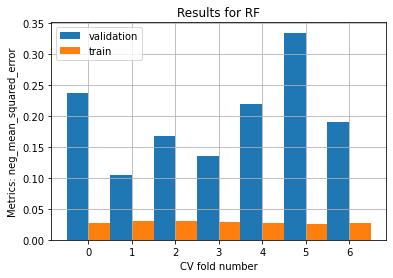

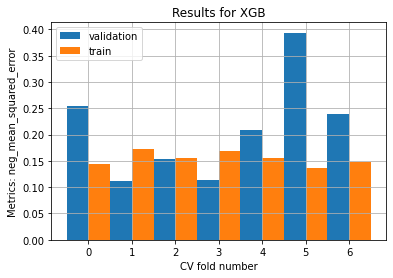

In [66]:
# %%pycodestyle
np.random.seed(RANDOM_SEED)

res = plot_cv_results(
    sklearn_models_dict_={
        model_name: model.model for model_name, model in all_models.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

In [67]:
shortlisted_models = {
    model.name: model for model in [
        RFModel, 
        # ElasticNetModel, 
        # SVRModel,
        XGBModel
    ]
}

# Fine tuning

## Grid search

In [56]:
grid_search_results = fit_grid_search(
    shortlisted_models,  # dict_subset(models, ['RF'])
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=4,
    scoring_='neg_mean_squared_error'
)

# grid_search_results = {
#     'RF': rf_grid_search_results['RF'],
#     'ElasticNet': elastic_grid_search_results['ElasticNet'],
#     'SVM reg': svm_grid_search_results['SVM reg']
# }

pep8(_ih)

Fitting RF
Fitting XGB



In [74]:
grid_search_results['XGB'].best_estimator_

GradientBoostingRegressor(max_depth=6, max_features='auto', n_estimators=7,
                          random_state=42, subsample=0.5)

## Randomized search

In [68]:
rand_search_results = fit_randomized_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=6,
    n_iter_=10,
    scoring_='neg_mean_squared_error'
)

Fitting RF
Fitting XGB


In [69]:
# print(rand_search_results.get('RF').best_estimator_)
# print(rand_search_results['SVM reg'].best_estimator_)
rand_search_results['XGB'].best_estimator_

GradientBoostingRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=6,
                          n_estimators=4, random_state=42, subsample=0.8)

# Check final models for overfit

Model      Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------  ----------------------  ----------------  ------------------------  ------------------
XGB                   -0.185104         0.0123209                 -0.222169           0.117532
RF                    -0.115443         0.0119362                 -0.19665            0.0872924


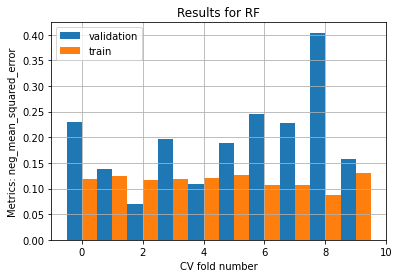

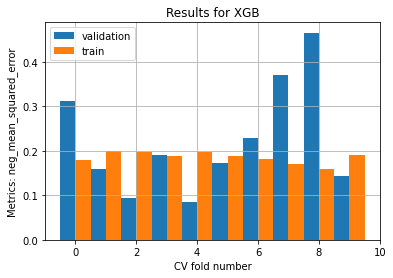

In [70]:
_ = plot_cv_results(
    sklearn_models_dict_ = {
        model_name: result.best_estimator_
        for model_name, result in rand_search_results.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=10,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

Model      Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------  ----------------------  ----------------  ------------------------  ------------------
RF                   -0.0935762         0.016756                  -0.244164           0.0590447
XGB                  -0.119921          0.0121145                 -0.213205           0.0621885


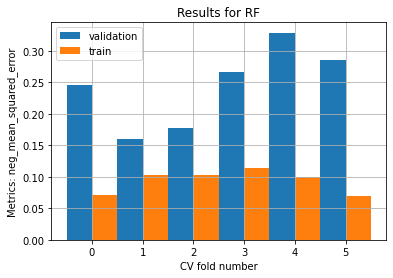

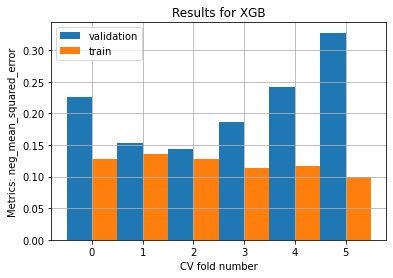

In [71]:
_ = plot_cv_results(
    sklearn_models_dict_ = {
        model_name: result.best_estimator_
        for model_name, result in grid_search_results.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=6,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

# Saving fine tuned candidates (retrained on train+val subset)

In [72]:
manager.save_models(
    {
        f'{model_name}_rand': result.best_estimator_
        for model_name, result in rand_search_results.items()
    }
)

# manager.save_models(
#     {
#         f'{model_name}_grid_search': result.best_estimator_
#         for model_name, result in grid_search_results.items()
#     }
# )